In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import random
from torch.autograd import Variable
import copy
from torch import nn, optim
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv
import time
import math


In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [3]:
class Argments():
  def __init__(self):
    self.batch_size = 40
    self.test_batch = 1000
    #self.global_epochs = 500
    self.local_epochs = 200
    self.lr = None
    self.momentum = 0.9
    self.weight_decay = 10**-4.0
    self.clip = 20.0
    self.partience = 10
    self.worker_num = 20
    #self.sample_num = 20
    self.unlabeleddata_size = 1000
    self.device = torch.device('cuda:0'if torch.cuda.is_available() else'cpu')
    self.criterion = nn.CrossEntropyLoss()
    
    self.alpha_label = 0.5
    self.alpha_size = 10

args = Argments()

In [4]:
# Tuned value
lr = 2

In [6]:
lr_list = []
lr_list.append(10**-3.0)
lr_list.append(10**-2.5)
lr_list.append(10**-2.0)
lr_list.append(10**-1.5)
lr_list.append(10**-1.0)
lr_list.append(10**-0.5)
lr_list.append(10**0.0)
lr_list.append(10**0.5)

args.lr = lr_list[lr]

In [9]:
class LocalDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label
    
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
class GlobalDataset(torch.utils.data.Dataset):
  def __init__(self,federated_dataset,transform=None):
    self.transform = transform
    self.data = []
    self.label = []
    for dataset in federated_dataset:
      for (data,label) in dataset:
        self.data.append(data)
        self.label.append(label)

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = self.label[idx]
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

class UnlabeledDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None):
    self.transform = transform
    self.data = []
    self.target = None

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = 'unlabeled'
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

In [10]:
def get_dataset(Centralized=False,unlabeled_data=False):
    
    transform_train = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomCrop(32, padding=2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])
    transform_test = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])

    # download train data
    all_trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
    #trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

    # download test data
    all_testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

    
    ## get unlabeled dataset
    if unlabeled_data:
        unlabeled_dataset = UnlabeledDataset(transform_test)
        idx = sorted(random.sample(range(len(all_trainset)),args.unlabeleddata_size))
        unlabeled_dataset.data = np.array([all_trainset.data[i]  for i in idx])
        all_trainset.data = np.delete(all_trainset.data,idx,0)
        all_trainset.targets = np.delete(all_trainset.targets,idx,0)
    all_train_data = np.array(all_trainset.data)
    all_train_label = np.array(all_trainset.targets)
    all_test_data = np.array(all_testset.data)
    all_test_label = np.array(all_testset.targets)
    print('Train:{} Test:{}'.format(len(all_train_data),len(all_test_data)))


    ## Data size heterogeneity
    data_proportions = np.random.dirichlet(np.repeat(args.alpha_size, args.worker_num))
    train_data_proportions = np.array([0 for _ in range(args.worker_num)])
    test_data_proportions = np.array([0 for _ in range(args.worker_num)])
    for i in range(len(data_proportions)):
        if i==(len(data_proportions)-1):
            train_data_proportions = train_data_proportions.astype('int64')
            test_data_proportions = test_data_proportions.astype('int64')
            train_data_proportions[-1] = len(all_train_data) - np.sum(train_data_proportions[:-1])
            test_data_proportions[-1] = len(all_test_data) - np.sum(test_data_proportions[:-1])
        else:
            train_data_proportions[i] = (data_proportions[i] * len(all_train_data))
            test_data_proportions[i] = (data_proportions[i] * len(all_test_data))
    min_size = 0
    K = 10

    '''
    label_list = np.arange(10)
    np.random.shuffle(label_list)
    '''
    label_list = list(range(K))


    ## Data distribution heterogeneity
    while min_size<10:
        idx_train_batch = [[] for _ in range(args.worker_num)]
        idx_test_batch = [[] for _ in range(args.worker_num)]
        for k in label_list:
            proportions_train = np.random.dirichlet(np.repeat(args.alpha_label, args.worker_num))
            proportions_test = copy.deepcopy(proportions_train)
            idx_k_train = np.where(all_train_label == k)[0]
            idx_k_test = np.where(all_test_label == k)[0]
            np.random.shuffle(idx_k_train)
            np.random.shuffle(idx_k_test)
            ## Balance (train)
            proportions_train = np.array([p*(len(idx_j)<train_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_train,idx_train_batch))])
            proportions_train = proportions_train/proportions_train.sum()
            proportions_train = (np.cumsum(proportions_train)*len(idx_k_train)).astype(int)[:-1]
            idx_train_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_train_batch,np.split(idx_k_train,proportions_train))]

            ## Balance (test)
            proportions_test = np.array([p*(len(idx_j)<test_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_test,idx_test_batch))])
            proportions_test = proportions_test/proportions_test.sum()
            proportions_test = (np.cumsum(proportions_test)*len(idx_k_test)).astype(int)[:-1]
            idx_test_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_test_batch,np.split(idx_k_test,proportions_test))]

            min_size = min([len(idx_j) for idx_j in idx_train_batch])

    federated_trainset = []
    federated_testset = []
    for i in range(args.worker_num):
        ## create trainset
        data = [all_train_data[idx] for idx in idx_train_batch[i]]
        label = [all_train_label[idx] for idx in idx_train_batch[i]]
        federated_trainset.append(LocalDataset())
        federated_trainset[-1].data = data
        federated_trainset[-1].label = label

        ## create testset
        data = [all_test_data[idx] for idx in idx_test_batch[i]]
        label = [all_test_label[idx] for idx in idx_test_batch[i]]
        federated_testset.append(LocalDataset())
        federated_testset[-1].data = data
        federated_testset[-1].label = label

        
    ## split trainset
    federated_valset = [None]*args.worker_num
    for i in range(args.worker_num):
        n_samples = len(federated_trainset[i])
        if n_samples==1:
            train_subset = federated_trainset[i]
            val_subset = copy.deepcopy(federated_trainset[i])
        else:
            train_size = int(len(federated_trainset[i]) * 0.8) 
            val_size = n_samples - train_size 
            train_subset,val_subset = torch.utils.data.random_split(federated_trainset[i], [train_size, val_size])

        federated_trainset[i] = DatasetFromSubset(train_subset)
        federated_valset[i] = DatasetFromSubset(val_subset)

    ## show data distribution
    H = 4
    W = 5
    fig, axs = plt.subplots(H, W, figsize=(20, 5))
    x = np.arange(1,11)
    for i, (trainset,valset,testset) in enumerate(zip(federated_trainset,federated_valset,federated_testset)):
        bottom = [0]*10
        count = [0]*10
        for _,label in trainset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in valset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in testset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        #axs[int(i/W), i%W].title("worker{}".format(i+1), fontsize=12, color = "green")

    plt.show()

    ## get global dataset
    if Centralized:
        global_trainset = GlobalDataset(federated_trainset)
        global_valset = GlobalDataset(federated_valset)
        global_testset =  GlobalDataset(federated_testset)
        
        #show_cifer(global_trainset.data,global_testset.label, cifar10_labels)

        global_trainset.transform = transform_train
        global_valset.transform = transform_test
        global_testset.transform = transform_test

        global_trainloader = torch.utils.data.DataLoader(global_trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
        global_valloader = torch.utils.data.DataLoader(global_valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
        global_testloader = torch.utils.data.DataLoader(global_testset,batch_size=args.test_batch,shuffle=False,num_workers=2)

    ## set transform
    for i in range(args.worker_num):
        federated_trainset[i].transform = transform_train
        federated_valset[i].transform = transform_test
        federated_testset[i].transform = transform_test
    
    if Centralized and unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader,unlabeled_dataset
    if Centralized:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader
    elif unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,unlabeled_dataset
    else:
        return federated_trainset,federated_valset,federated_testset

Files already downloaded and verified
Files already downloaded and verified
Train:49000 Test:10000


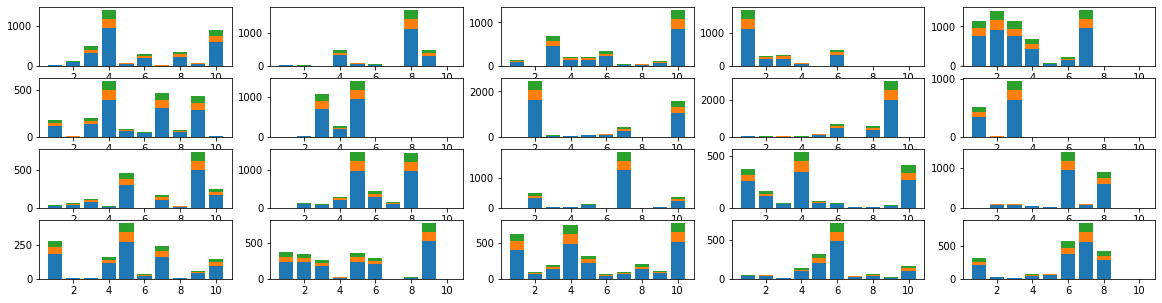

In [11]:
federated_trainset,federated_valset,federated_testset,unlabeled_dataset = get_dataset(unlabeled_data=True)

In [12]:
total = [0,0,0]
for i in range(args.worker_num):
    total[0]+=len(federated_trainset[i])
    total[1]+=len(federated_valset[i])
    total[2]+=len(federated_testset[i])
print(total)

[39191, 9809, 10000]


In [14]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            #print("in_channels: {}, v: {}".format(in_channels, v))
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


class VGGConvBlocks(nn.Module):
    '''
    VGG containers that only contains the conv layers 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class VGGContainer(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, input_dim, hidden_dims, num_classes=10):
        super(VGGContainer, self).__init__()
        self.features = features
        # note: we hard coded here a bit by assuming we only have two hidden layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Linear(hidden_dims[1], num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def matched_vgg11(matched_shapes):
    # [(67, 27), (67,), (132, 603), (132,), (260, 1188), (260,), (261, 2340), (261,), (516, 2349), (516,), (517, 4644), (517,), 
    # (516, 4653), (516,), (516, 4644), (516,), (516, 515), (515,), (515, 515), (515,), (515, 10), (10,)]
    processed_matched_shape = [matched_shapes[0][0], 
                                'M', 
                                matched_shapes[2][0], 
                                'M', 
                                matched_shapes[4][0], 
                                matched_shapes[6][0], 
                                'M', 
                                matched_shapes[8][0], 
                                matched_shapes[10][0], 
                                'M', 
                                matched_shapes[12][0], 
                                matched_shapes[14][0], 
                                'M']
    return VGGContainer(make_layers(processed_matched_shape), input_dim=matched_shapes[16][0], 
            hidden_dims=[matched_shapes[16][1], matched_shapes[18][1]], num_classes=10)


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn(num_classes=10):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes=num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [15]:
class Server():
  def __init__(self):
    self.model = vgg13()

  def create_worker(self,federated_trainset,federated_valset,federated_testset):
    workers = []
    for i in range(args.worker_num):
      workers.append(Worker(federated_trainset[i],federated_valset[i],federated_testset[i]))
    return workers

  def sample_worker(self,workers):
    sample_worker = []
    sample_worker_num = random.sample(range(args.worker_num),args.sample_num)
    for i in sample_worker_num:
      sample_worker.append(workers[i])
    return sample_worker


  def send_model(self,workers):
    nums = 0
    for worker in workers:
      nums += worker.train_data_num

    for worker in workers:
      worker.aggregation_weight = 1.0*worker.train_data_num/nums
      worker.model = copy.deepcopy(self.model)
      worker.model = worker.model.to(args.device)

  def aggregate_model(self,workers):   
    new_params = OrderedDict()
    for i,worker in enumerate(workers):
      worker_state = worker.model.state_dict()
      for key in worker_state.keys():
        if i==0:
          new_params[key] = worker_state[key]*worker.aggregation_weight
        else:
          new_params[key] += worker_state[key]*worker.aggregation_weight
      worker.model = worker.model.to('cpu')
      del worker.model
    self.model.load_state_dict(new_params)

In [16]:
class Worker():
  def __init__(self,trainset,valset,testset):
    self.trainloader = torch.utils.data.DataLoader(trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.valloader = torch.utils.data.DataLoader(valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.testloader = torch.utils.data.DataLoader(testset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.model = None
    self.train_data_num = len(trainset)
    self.test_data_num = len(testset)
    self.aggregation_weight = None

  def local_train(self):
    acc_valid,loss_valid = train(self.model,args.criterion,self.trainloader,self.valloader,args.local_epochs,partience=args.partience,early_stop=True)
    return acc_valid[-1],loss_valid[-1]

In [17]:
def train(model,criterion,trainloader,valloader,epochs,partience=0,early_stop=False):
  if early_stop:
    early_stopping = Early_Stopping(partience)

  acc_valid = []
  loss_valid = []
  optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    count = 0
    model.train()
    for (data,labels) in trainloader:
      data,labels = Variable(data),Variable(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs,labels)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()
      
    model.eval()
    for (data,labels) in valloader:
      count += len(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      
    print('Epoch:{}  accuracy:{}  loss:{}'.format(epoch+1,100.0*correct/count,running_loss/len(valloader)))
    acc_valid.append(100.0*correct/count)
    loss_valid.append(running_loss/len(valloader))
    if early_stop:
      if early_stopping.validate(running_loss):
        print('Early Stop')
        return acc_valid,loss_valid

  return acc_valid,loss_valid

In [18]:
def test(model,criterion,testloader):
  model.eval()
  running_loss = 0.0
  correct = 0
  count = 0
  for (data,labels) in testloader:
    data,labels = data.to(args.device),labels.to(args.device)
    outputs = model(data)
    running_loss += criterion(outputs,labels).item()
    predicted = torch.argmax(outputs,dim=1)
    correct += (predicted==labels).sum().item()
    count += len(labels)

  accuracy = 100.0*correct/count
  loss = running_loss/len(testloader)


  return accuracy,loss

In [19]:
class Early_Stopping():
  def __init__(self,partience):
    self.step = 0
    self.loss = float('inf')
    self.partience = partience

  def validate(self,loss):
    if self.loss<loss:
      self.step += 1
      if self.step>self.partience:
        return True
    else:
      self.step = 0
      self.loss = loss

    return False

In [20]:
server = Server()
workers = server.create_worker(federated_trainset,federated_valset,federated_testset)
acc_valid = []
loss_valid = []

early_stopping = Early_Stopping(args.partience)

start = time.time()

for i,worker in enumerate(workers):
    print('Worker{} start'.format(i+1))
    worker.model = vgg13()
    worker.model = worker.model.to(args.device)
    acc_tmp,loss_tmp = worker.local_train()
    acc_valid.append(acc_tmp)
    loss_valid.append(loss_tmp)
    worker.model = worker.model.to('cpu')
    
end = time.time()

Worker1 start
Epoch:1  accuracy:33.541341653666144  loss:2.099371910095215
Epoch:2  accuracy:33.541341653666144  loss:1.8135875463485718
Epoch:3  accuracy:33.541341653666144  loss:1.81685209274292
Epoch:4  accuracy:33.541341653666144  loss:1.8065166473388672
Epoch:5  accuracy:33.541341653666144  loss:1.8002419471740723
Epoch:6  accuracy:33.541341653666144  loss:1.7978066205978394
Epoch:7  accuracy:33.541341653666144  loss:1.788761854171753
Epoch:8  accuracy:33.697347893915754  loss:1.7752641439437866
Epoch:9  accuracy:40.5616224648986  loss:1.7485074996948242
Epoch:10  accuracy:44.14976599063962  loss:1.684731364250183
Epoch:11  accuracy:43.8377535101404  loss:1.6683796644210815
Epoch:12  accuracy:42.90171606864275  loss:1.6776244640350342
Epoch:13  accuracy:46.02184087363494  loss:1.6339290142059326
Epoch:14  accuracy:46.48985959438377  loss:1.6231786012649536
Epoch:15  accuracy:46.64586583463338  loss:1.6162793636322021
Epoch:16  accuracy:47.113884555382214  loss:1.5939615964889526
E

Epoch:44  accuracy:78.21576763485477  loss:0.6721742153167725
Epoch:45  accuracy:76.14107883817428  loss:0.6861302256584167
Epoch:46  accuracy:76.55601659751038  loss:0.6868011355400085
Epoch:47  accuracy:75.10373443983403  loss:0.7324874401092529
Epoch:48  accuracy:75.93360995850622  loss:0.6983755230903625
Epoch:49  accuracy:78.00829875518673  loss:0.6562207937240601
Epoch:50  accuracy:77.38589211618257  loss:0.6823397278785706
Epoch:51  accuracy:77.17842323651452  loss:0.6577373743057251
Epoch:52  accuracy:76.55601659751038  loss:0.6865141987800598
Epoch:53  accuracy:75.72614107883817  loss:0.7130341529846191
Epoch:54  accuracy:76.97095435684648  loss:0.6708306670188904
Epoch:55  accuracy:73.85892116182572  loss:0.7311116456985474
Epoch:56  accuracy:77.17842323651452  loss:0.6728253960609436
Epoch:57  accuracy:77.17842323651452  loss:0.6518771052360535
Epoch:58  accuracy:78.63070539419087  loss:0.6455055475234985
Epoch:59  accuracy:76.55601659751038  loss:0.7007463574409485
Epoch:60

Epoch:77  accuracy:66.015625  loss:1.0796821117401123
Epoch:78  accuracy:66.6015625  loss:1.0692459344863892
Epoch:79  accuracy:66.6015625  loss:1.063986897468567
Epoch:80  accuracy:66.2109375  loss:1.060705542564392
Epoch:81  accuracy:64.84375  loss:1.0974315404891968
Epoch:82  accuracy:67.1875  loss:1.0692484378814697
Epoch:83  accuracy:64.0625  loss:1.093552827835083
Epoch:84  accuracy:65.0390625  loss:1.1239569187164307
Epoch:85  accuracy:66.015625  loss:1.1100894212722778
Epoch:86  accuracy:64.6484375  loss:1.1079164743423462
Epoch:87  accuracy:64.84375  loss:1.1014788150787354
Epoch:88  accuracy:66.2109375  loss:1.0760153532028198
Epoch:89  accuracy:64.6484375  loss:1.0477863550186157
Epoch:90  accuracy:67.3828125  loss:1.078123927116394
Epoch:91  accuracy:67.578125  loss:1.0270754098892212
Epoch:92  accuracy:66.015625  loss:1.0228915214538574
Epoch:93  accuracy:66.015625  loss:1.0511009693145752
Epoch:94  accuracy:68.1640625  loss:1.066896915435791
Epoch:95  accuracy:68.1640625 

Epoch:97  accuracy:76.36363636363636  loss:0.7206814289093018
Epoch:98  accuracy:76.16161616161617  loss:0.6908677816390991
Epoch:99  accuracy:78.38383838383838  loss:0.6671943664550781
Epoch:100  accuracy:77.77777777777777  loss:0.7139940857887268
Epoch:101  accuracy:76.16161616161617  loss:0.7034269571304321
Epoch:102  accuracy:77.17171717171718  loss:0.6964133381843567
Epoch:103  accuracy:75.35353535353535  loss:0.7190980911254883
Epoch:104  accuracy:79.1919191919192  loss:0.6914488077163696
Epoch:105  accuracy:72.32323232323232  loss:0.8140285015106201
Epoch:106  accuracy:77.17171717171718  loss:0.6728538274765015
Epoch:107  accuracy:76.96969696969697  loss:0.7620608806610107
Epoch:108  accuracy:73.13131313131314  loss:0.8237523436546326
Epoch:109  accuracy:79.1919191919192  loss:0.6932880282402039
Epoch:110  accuracy:77.17171717171718  loss:0.7048206925392151
Early Stop
Worker5 start
Epoch:1  accuracy:20.916334661354583  loss:2.1272647380828857
Epoch:2  accuracy:25.99601593625498 

Epoch:21  accuracy:41.76136363636363  loss:1.5761581659317017
Epoch:22  accuracy:45.17045454545455  loss:1.5921024084091187
Epoch:23  accuracy:44.03409090909091  loss:1.5751595497131348
Epoch:24  accuracy:40.90909090909091  loss:1.6230403184890747
Epoch:25  accuracy:47.15909090909091  loss:1.535473346710205
Epoch:26  accuracy:46.875  loss:1.5433160066604614
Epoch:27  accuracy:49.71590909090909  loss:1.5008537769317627
Epoch:28  accuracy:46.59090909090909  loss:1.5174354314804077
Epoch:29  accuracy:49.14772727272727  loss:1.508409857749939
Epoch:30  accuracy:49.43181818181818  loss:1.490461826324463
Epoch:31  accuracy:50.28409090909091  loss:1.4973315000534058
Epoch:32  accuracy:50.85227272727273  loss:1.4765843152999878
Epoch:33  accuracy:50.0  loss:1.4812783002853394
Epoch:34  accuracy:48.01136363636363  loss:1.4963040351867676
Epoch:35  accuracy:45.17045454545455  loss:1.5276786088943481
Epoch:36  accuracy:51.42045454545455  loss:1.4883617162704468
Epoch:37  accuracy:51.1363636363636

Epoch:60  accuracy:47.96573875802998  loss:0.9500992894172668
Epoch:61  accuracy:47.96573875802998  loss:0.9310749173164368
Epoch:62  accuracy:39.82869379014989  loss:0.9341956973075867
Epoch:63  accuracy:41.32762312633833  loss:0.9407156705856323
Epoch:64  accuracy:47.96573875802998  loss:0.9364414811134338
Epoch:65  accuracy:47.96573875802998  loss:0.9445703029632568
Epoch:66  accuracy:41.32762312633833  loss:0.945493757724762
Epoch:67  accuracy:47.96573875802998  loss:0.9371464848518372
Epoch:68  accuracy:47.96573875802998  loss:0.9442412257194519
Epoch:69  accuracy:47.96573875802998  loss:0.9224370718002319
Epoch:70  accuracy:49.46466809421842  loss:0.9354288578033447
Epoch:71  accuracy:47.96573875802998  loss:0.9257603883743286
Epoch:72  accuracy:47.96573875802998  loss:0.9301391243934631
Epoch:73  accuracy:47.96573875802998  loss:0.9454692602157593
Epoch:74  accuracy:47.96573875802998  loss:0.928007185459137
Epoch:75  accuracy:47.96573875802998  loss:0.9401116371154785
Epoch:76  

Epoch:6  accuracy:50.86848635235732  loss:1.1571979522705078
Epoch:7  accuracy:50.86848635235732  loss:1.1378607749938965
Epoch:8  accuracy:50.86848635235732  loss:1.1088165044784546
Epoch:9  accuracy:50.62034739454094  loss:1.1341267824172974
Epoch:10  accuracy:50.86848635235732  loss:1.1352747678756714
Epoch:11  accuracy:51.116625310173696  loss:1.0607256889343262
Epoch:12  accuracy:51.86104218362283  loss:1.051608681678772
Epoch:13  accuracy:53.72208436724566  loss:1.0406324863433838
Epoch:14  accuracy:57.69230769230769  loss:1.017327904701233
Epoch:15  accuracy:58.80893300248139  loss:1.0015180110931396
Epoch:16  accuracy:57.81637717121588  loss:1.0027692317962646
Epoch:17  accuracy:58.188585607940446  loss:0.9992935657501221
Epoch:18  accuracy:62.15880893300248  loss:0.9770705699920654
Epoch:19  accuracy:63.15136476426799  loss:0.9422730207443237
Epoch:20  accuracy:59.55334987593052  loss:0.9719361662864685
Epoch:21  accuracy:63.39950372208437  loss:0.9236592054367065
Epoch:22  ac

Epoch:53  accuracy:83.11688311688312  loss:0.5165351033210754
Epoch:54  accuracy:83.50649350649351  loss:0.5194207429885864
Epoch:55  accuracy:83.37662337662337  loss:0.5332645177841187
Epoch:56  accuracy:83.37662337662337  loss:0.5066156983375549
Epoch:57  accuracy:83.76623376623377  loss:0.515387773513794
Epoch:58  accuracy:82.85714285714286  loss:0.5141118168830872
Epoch:59  accuracy:83.63636363636364  loss:0.5010185241699219
Epoch:60  accuracy:82.85714285714286  loss:0.5101397037506104
Epoch:61  accuracy:83.24675324675324  loss:0.5152795314788818
Epoch:62  accuracy:83.63636363636364  loss:0.4963507354259491
Epoch:63  accuracy:84.41558441558442  loss:0.5015478134155273
Epoch:64  accuracy:83.76623376623377  loss:0.5234408378601074
Epoch:65  accuracy:83.76623376623377  loss:0.5240399837493896
Epoch:66  accuracy:84.28571428571429  loss:0.5102056264877319
Epoch:67  accuracy:84.54545454545455  loss:0.4993908405303955
Epoch:68  accuracy:82.98701298701299  loss:0.5484989285469055
Epoch:69 

Epoch:105  accuracy:85.82995951417004  loss:0.368880033493042
Epoch:106  accuracy:87.04453441295547  loss:0.3773353397846222
Epoch:107  accuracy:86.23481781376518  loss:0.3775840401649475
Epoch:108  accuracy:88.25910931174089  loss:0.37473398447036743
Epoch:109  accuracy:83.80566801619433  loss:0.43037229776382446
Epoch:110  accuracy:87.04453441295547  loss:0.3573179841041565
Epoch:111  accuracy:87.4493927125506  loss:0.37386733293533325
Epoch:112  accuracy:88.25910931174089  loss:0.3681524395942688
Epoch:113  accuracy:87.04453441295547  loss:0.3839677572250366
Epoch:114  accuracy:85.82995951417004  loss:0.39130911231040955
Epoch:115  accuracy:87.4493927125506  loss:0.38256406784057617
Epoch:116  accuracy:87.85425101214575  loss:0.38217687606811523
Epoch:117  accuracy:87.85425101214575  loss:0.39854565262794495
Epoch:118  accuracy:87.4493927125506  loss:0.3525361120700836
Epoch:119  accuracy:88.25910931174089  loss:0.3698672950267792
Epoch:120  accuracy:86.63967611336032  loss:0.380485

Epoch:108  accuracy:65.04854368932038  loss:1.0514410734176636
Epoch:109  accuracy:65.37216828478964  loss:1.1137349605560303
Epoch:110  accuracy:65.04854368932038  loss:1.172960638999939
Epoch:111  accuracy:64.07766990291262  loss:1.085951805114746
Epoch:112  accuracy:64.40129449838187  loss:1.0999208688735962
Epoch:113  accuracy:64.40129449838187  loss:1.06645667552948
Epoch:114  accuracy:63.43042071197411  loss:1.1125662326812744
Epoch:115  accuracy:65.37216828478964  loss:1.0903379917144775
Epoch:116  accuracy:65.6957928802589  loss:1.118165135383606
Epoch:117  accuracy:64.72491909385113  loss:1.1490058898925781
Epoch:118  accuracy:65.37216828478964  loss:1.183044195175171
Epoch:119  accuracy:63.75404530744336  loss:1.148322343826294
Early Stop
Worker12 start
Epoch:1  accuracy:34.50807635829662  loss:1.9726345539093018
Epoch:2  accuracy:34.50807635829662  loss:1.5255144834518433
Epoch:3  accuracy:34.50807635829662  loss:1.5078673362731934
Epoch:4  accuracy:35.242290748898675  loss:

Epoch:27  accuracy:75.98343685300208  loss:0.6686977744102478
Epoch:28  accuracy:72.04968944099379  loss:0.7623876333236694
Epoch:29  accuracy:75.77639751552795  loss:0.6694399118423462
Epoch:30  accuracy:75.56935817805383  loss:0.668053150177002
Epoch:31  accuracy:75.3623188405797  loss:0.6754130721092224
Epoch:32  accuracy:76.81159420289855  loss:0.6478107571601868
Epoch:33  accuracy:75.98343685300208  loss:0.6440690755844116
Epoch:34  accuracy:76.19047619047619  loss:0.626365065574646
Epoch:35  accuracy:76.3975155279503  loss:0.6424595713615417
Epoch:36  accuracy:76.81159420289855  loss:0.6357445120811462
Epoch:37  accuracy:76.60455486542443  loss:0.6545073986053467
Epoch:38  accuracy:77.01863354037268  loss:0.6282893419265747
Epoch:39  accuracy:77.22567287784679  loss:0.6742347478866577
Epoch:40  accuracy:77.01863354037268  loss:0.6857396364212036
Epoch:41  accuracy:76.60455486542443  loss:0.6288968920707703
Epoch:42  accuracy:77.01863354037268  loss:0.6187373995780945
Epoch:43  ac

Epoch:81  accuracy:64.53900709219859  loss:1.0644515752792358
Epoch:82  accuracy:69.14893617021276  loss:0.928861141204834
Early Stop
Worker15 start
Epoch:1  accuracy:49.2239467849224  loss:1.9829120635986328
Epoch:2  accuracy:49.2239467849224  loss:1.3236126899719238
Epoch:3  accuracy:49.2239467849224  loss:1.2867668867111206
Epoch:4  accuracy:49.2239467849224  loss:1.2448078393936157
Epoch:5  accuracy:49.2239467849224  loss:1.239793300628662
Epoch:6  accuracy:49.2239467849224  loss:1.2423893213272095
Epoch:7  accuracy:49.2239467849224  loss:1.2366023063659668
Epoch:8  accuracy:49.2239467849224  loss:1.2477129697799683
Epoch:9  accuracy:49.2239467849224  loss:1.235208511352539
Epoch:10  accuracy:49.2239467849224  loss:1.2399652004241943
Epoch:11  accuracy:49.2239467849224  loss:1.2247426509857178
Epoch:12  accuracy:49.2239467849224  loss:1.2273657321929932
Epoch:13  accuracy:49.2239467849224  loss:1.2275283336639404
Epoch:14  accuracy:49.2239467849224  loss:1.2354069948196411
Epoch:15

Epoch:132  accuracy:78.93569844789357  loss:0.8021411299705505
Epoch:133  accuracy:76.71840354767184  loss:0.9111276865005493
Epoch:134  accuracy:78.27050997782705  loss:0.8892696499824524
Early Stop
Worker16 start
Epoch:1  accuracy:8.810572687224669  loss:2.29965877532959
Epoch:2  accuracy:31.718061674008812  loss:2.2602832317352295
Epoch:3  accuracy:31.718061674008812  loss:2.2064056396484375
Epoch:4  accuracy:31.718061674008812  loss:2.0898611545562744
Epoch:5  accuracy:31.718061674008812  loss:1.8834837675094604
Epoch:6  accuracy:31.718061674008812  loss:1.855195164680481
Epoch:7  accuracy:31.718061674008812  loss:1.8360410928726196
Epoch:8  accuracy:31.718061674008812  loss:1.8233717679977417
Epoch:9  accuracy:31.718061674008812  loss:1.8236377239227295
Epoch:10  accuracy:31.718061674008812  loss:1.8175534009933472
Epoch:11  accuracy:31.718061674008812  loss:1.8175859451293945
Epoch:12  accuracy:31.718061674008812  loss:1.8117164373397827
Epoch:13  accuracy:31.718061674008812  los

Epoch:33  accuracy:42.7536231884058  loss:1.5309685468673706
Epoch:34  accuracy:45.410628019323674  loss:1.4826548099517822
Epoch:35  accuracy:43.96135265700483  loss:1.4693647623062134
Epoch:36  accuracy:45.65217391304348  loss:1.4544841051101685
Epoch:37  accuracy:45.893719806763286  loss:1.4317351579666138
Epoch:38  accuracy:42.99516908212561  loss:1.4631965160369873
Epoch:39  accuracy:43.23671497584541  loss:1.5582537651062012
Epoch:40  accuracy:43.96135265700483  loss:1.5450282096862793
Epoch:41  accuracy:43.96135265700483  loss:1.4550058841705322
Epoch:42  accuracy:42.51207729468599  loss:1.4787933826446533
Epoch:43  accuracy:44.44444444444444  loss:1.445475697517395
Epoch:44  accuracy:44.44444444444444  loss:1.3821097612380981
Epoch:45  accuracy:44.927536231884055  loss:1.3869438171386719
Epoch:46  accuracy:43.71980676328502  loss:1.4050487279891968
Epoch:47  accuracy:44.927536231884055  loss:1.3789606094360352
Epoch:48  accuracy:46.13526570048309  loss:1.3998483419418335
Epoch:

Epoch:37  accuracy:55.39033457249071  loss:1.38275146484375
Epoch:38  accuracy:54.46096654275093  loss:1.3955761194229126
Epoch:39  accuracy:57.0631970260223  loss:1.3586597442626953
Epoch:40  accuracy:55.204460966542754  loss:1.3751834630966187
Epoch:41  accuracy:56.319702602230485  loss:1.39315664768219
Epoch:42  accuracy:57.0631970260223  loss:1.3225524425506592
Epoch:43  accuracy:56.50557620817844  loss:1.3390922546386719
Epoch:44  accuracy:57.99256505576208  loss:1.3172427415847778
Epoch:45  accuracy:53.90334572490706  loss:1.4545278549194336
Epoch:46  accuracy:54.646840148698885  loss:1.3642055988311768
Epoch:47  accuracy:56.50557620817844  loss:1.373696208000183
Epoch:48  accuracy:55.94795539033457  loss:1.3377649784088135
Epoch:49  accuracy:56.69144981412639  loss:1.307786464691162
Epoch:50  accuracy:58.17843866171004  loss:1.2843097448349
Epoch:51  accuracy:57.24907063197026  loss:1.3223522901535034
Epoch:52  accuracy:56.69144981412639  loss:1.3147344589233398
Epoch:53  accura

Epoch:53  accuracy:47.12643678160919  loss:1.470975637435913
Epoch:54  accuracy:44.44444444444444  loss:1.519160270690918
Epoch:55  accuracy:49.04214559386973  loss:1.4862064123153687
Epoch:56  accuracy:49.42528735632184  loss:1.5051777362823486
Epoch:57  accuracy:49.04214559386973  loss:1.446708083152771
Epoch:58  accuracy:48.275862068965516  loss:1.432154655456543
Epoch:59  accuracy:48.65900383141762  loss:1.4290939569473267
Epoch:60  accuracy:46.74329501915709  loss:1.4302477836608887
Epoch:61  accuracy:47.509578544061306  loss:1.4263962507247925
Epoch:62  accuracy:49.42528735632184  loss:1.4373170137405396
Epoch:63  accuracy:49.04214559386973  loss:1.4145522117614746
Epoch:64  accuracy:48.275862068965516  loss:1.4102108478546143
Epoch:65  accuracy:48.275862068965516  loss:1.443561315536499
Epoch:66  accuracy:50.191570881226056  loss:1.3966104984283447
Epoch:67  accuracy:45.593869731800766  loss:1.4731919765472412
Epoch:68  accuracy:48.65900383141762  loss:1.4305649995803833
Epoch:6

Epoch:42  accuracy:60.46511627906977  loss:1.05287766456604
Epoch:43  accuracy:59.43152454780362  loss:1.150733470916748
Epoch:44  accuracy:55.81395348837209  loss:1.1776515245437622
Epoch:45  accuracy:63.049095607235145  loss:1.054133653640747
Epoch:46  accuracy:66.40826873385014  loss:1.027456521987915
Epoch:47  accuracy:64.34108527131782  loss:1.0179654359817505
Epoch:48  accuracy:65.37467700258398  loss:1.0326298475265503
Epoch:49  accuracy:66.66666666666667  loss:1.016062617301941
Epoch:50  accuracy:59.43152454780362  loss:1.1401026248931885
Epoch:51  accuracy:66.14987080103359  loss:0.988311767578125
Epoch:52  accuracy:65.37467700258398  loss:1.0377569198608398
Epoch:53  accuracy:67.70025839793281  loss:0.9616113901138306
Epoch:54  accuracy:67.44186046511628  loss:0.9528276324272156
Epoch:55  accuracy:70.80103359173127  loss:0.9329350590705872
Epoch:56  accuracy:65.11627906976744  loss:0.9465048909187317
Epoch:57  accuracy:64.85788113695091  loss:1.021567463874817
Epoch:58  accur

In [22]:
acc_test = []
loss_test = []

start = time.time()

for i,worker in enumerate(workers):
    worker.model = worker.model.to(args.device)
    acc_tmp,loss_tmp = test(worker.model,args.criterion,worker.testloader)
    acc_test.append(acc_tmp)
    loss_test.append(loss_tmp)
    print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
    worker.model = worker.model.to('cpu')
    
end = time.time()

Worker1 accuracy:67.28110599078342  loss:1.033393383026123
Worker2 accuracy:81.9672131147541  loss:0.6227041482925415
Worker3 accuracy:65.9047619047619  loss:1.058107614517212
Worker4 accuracy:79.16666666666667  loss:0.6506220698356628
Worker5 accuracy:77.46341463414635  loss:0.43201246578246355
Worker6 accuracy:57.938718662952645  loss:1.2745777368545532
Worker7 accuracy:73.89473684210526  loss:0.6818184852600098
Worker8 accuracy:81.60779537149817  loss:0.5994413495063782
Worker9 accuracy:83.94904458598727  loss:0.5988562107086182
Worker10 accuracy:83.33333333333333  loss:0.40492624044418335
Worker11 accuracy:68.57142857142857  loss:1.0044238567352295
Worker12 accuracy:69.20863309352518  loss:0.9387714862823486
Worker13 accuracy:77.55102040816327  loss:0.6488577127456665
Worker14 accuracy:68.62068965517241  loss:1.1223710775375366
Worker15 accuracy:77.12418300653594  loss:1.0529385805130005
Worker16 accuracy:44.54148471615721  loss:1.3932582139968872
Worker17 accuracy:65.5660377358490

In [24]:
acc_valid_avg = sum(acc_valid)/len(acc_valid)
loss_valid_avg = sum(loss_valid)/len(loss_valid)
print('Validation  loss:{}  accuracy:{}'.format(loss_valid_avg,acc_valid_avg))

acc_test_avg = sum(acc_test)/len(acc_test)
loss_test_avg = sum(loss_test)/len(loss_test)
print('Test  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Validation  loss:0.8803130548447371  accuracy:71.54032417602966
Test  loss:0.8996922625694423  accuracy:71.00174439139948
